In [1]:
import numpy as np
import scipy
import torch
import pandas as pd

import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader


In [2]:
## define neural network

class NNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2a = nn.Linear(hidden_dim, 1)
        self.layer2b = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        out1 = self.layer2a(x).squeeze()
        out2 = self.layer2b(x).squeeze()
        return out1, out2
    
    
def quantileLoss(y_out_l, y_out_u, y, alpha):
    lower_loss = torch.max( (alpha/2)*(y - y_out_l), (alpha/2-1)*(y - y_out_l) )
    upper_loss = torch.max( (1-alpha/2)*(y - y_out_u), (-alpha/2)*(y - y_out_u) )
    return torch.mean(lower_loss + upper_loss)


In [3]:
## define data generation mechanism

def generateNonlinearY(x, sigma):
    n = len(x)
    eps1 = np.random.gamma(2, 2, n) - 4
    eps2 = np.random.normal(0, .5, n)
    
    y = 2*np.maximum(x, 0) + sigma * ( (x + .5) * eps1 + eps2)
    return y

Text(0, 0.5, 'y')

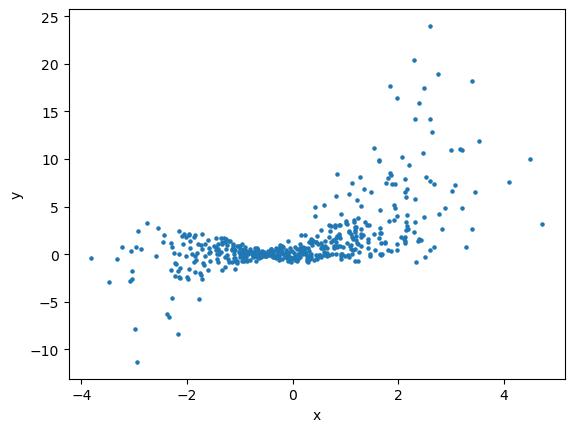

In [4]:
## generating data

import matplotlib.pyplot as plt

n = 1000
sigma = 0.5
alpha = 0.1

x = np.random.randn(n)*1.5
y = generateNonlinearY(x, sigma)

ntrain = 500
xtrain = x[:ntrain]
ytrain = y[:ntrain]
xtest = x[ntrain:]
ytest = y[ntrain:]

## plot data
plt.scatter(xtrain, ytrain, s=5)
plt.xlabel('x')
plt.ylabel('y')


In [7]:
## train neural network on first half of training data    

x_train = torch.tensor(xtrain.reshape(-1, 1), dtype=torch.float32)
y_train = torch.tensor(ytrain, dtype=torch.float32)

train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True)

input_dim = 1
hidden_dim = 10

model = NNet(input_dim, hidden_dim)
lr = 0.2
epochs = 60
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_out_l, y_out_u = model(x_batch)
        loss = quantileLoss(y_out_l, y_out_u, y_batch, alpha)
        loss.backward()
        optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')



Epoch 0, Loss: 0.3677663207054138
Epoch 20, Loss: 0.20660564303398132
Epoch 40, Loss: 0.22157129645347595


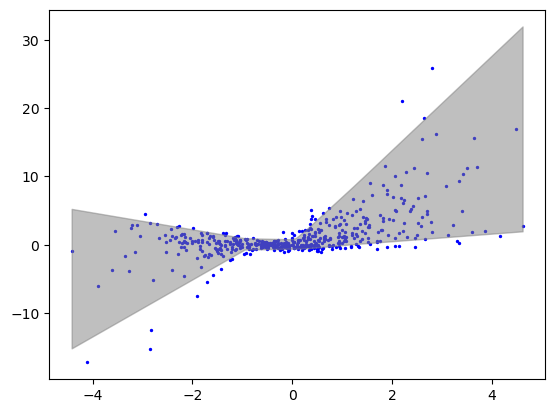

In [6]:
## plot prediction intervals

import matplotlib.pyplot as plt

x_test = torch.tensor(xtest.reshape(-1, 1), dtype=torch.float32)
out_test = model(x_test)

upper = out_test[0].detach().numpy()
lower = out_test[1].detach().numpy()

sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]
eps = np.random.randn(len(xgrid))

plt.scatter(xgrid, ygrid, color='blue', s=2)

##plt.plot(xgrid, lower[sorted_ix], color='red')
##plt.plot(xgrid, upper[sorted_ix], color='orange')
plt.fill_between(xgrid, lower[sorted_ix], upper[sorted_ix], color='gray', alpha=0.5)